In [1]:
import torch

from einops import rearrange
from functools import partial
from omegaconf import OmegaConf
from pathlib import Path

from lola.autoencoder import get_autoencoder
from lola.data import field_postprocess, field_preprocess, get_well_inputs, get_well_multi_dataset
from lola.plot import plot_fields, plot_psd

torch.set_float32_matmul_precision("high")

device = torch.device("cpu")
rng = torch.manual_seed(0)

In [2]:
# runpath = Path("~/ceph/lola/runs/ae/gf09iy5g_gravity_cooling_dcae_3d_f8c4_large/")
# runpath = Path("~/ceph/lola/runs/ae/0zc7afa4_gravity_cooling_dcae_3d_f8c16_large/")
runpath = Path("~/ceph/lola/runs/ae/dnzp6wv7_gravity_cooling_dcae_3d_f8c64_large/")
runpath = runpath.expanduser()

cfg = OmegaConf.load(runpath / "config.yaml")

## Data

In [3]:
dataset = get_well_multi_dataset(
    path="~/ceph/the_well/datasets",
    physics=cfg.dataset.physics,
    split="train",
    steps=1,
    include_filters=cfg.dataset.include_filters,
)

preprocess = partial(
    field_preprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

postprocess = partial(
    field_postprocess,
    mean=torch.as_tensor(cfg.dataset.stats.mean, device=device),
    std=torch.as_tensor(cfg.dataset.stats.std, device=device),
    transform=cfg.dataset.transform,
)

## Autoencoder

In [4]:
autoencoder = get_autoencoder(**cfg.ae)
autoencoder.load_state_dict(torch.load(runpath / "state.pth", weights_only=True, map_location=device))
autoencoder.to(device)
autoencoder.eval()

AutoEncoder(
  (encoder): DCEncoder(
    (patch): Rearrange('... C (L l) (H h) (W w) -> ... (C l h w) L H W', l=1, h=1, w=1)
    (descent): ModuleList(
      (0): ModuleList(
        (0): Conv3d(6, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-4)
          (attn): Identity()
          (ffn): Sequential(
            (0): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
            (1): SiLU()
            (2): Dropout(p=0.05, inplace=False)
            (3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          )
        )
      )
      (1): ModuleList(
        (0): Sequential(
          (0): Rearrange('... C (L l) (H h) (W w) -> ... (C l h w) L H W', l=2, h=2, w=2)
          (1): Conv3d(512, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        )
        (1-3): 3 x ResBlock(
          (norm): LayerNorm(dim=-4)
          (attn): Identi

In [5]:
sum(p.numel() for p in autoencoder.parameters())

741019014

## Evaluation

In [6]:
x, _ = get_well_inputs(dataset[4321], device=device)
x = preprocess(x)
x = rearrange(x, "1 ... C -> C ...")

In [7]:
with torch.no_grad():
    z = autoencoder.encode(x.unsqueeze(0))
    y = autoencoder.decode(z).squeeze(0)

error = (x - y).abs().reshape(dataset.metadata.n_fields, -1)

In [8]:
(
    error.mean(axis=-1),
    error.square().mean(axis=-1).sqrt(),
    error.median(axis=-1).values,
    error.max(axis=-1).values,
)

(tensor([0.0204, 0.0114, 0.0049, 0.0305, 0.0299, 0.0303]),
 tensor([0.0262, 0.0147, 0.0065, 0.0394, 0.0386, 0.0391]),
 tensor([0.0165, 0.0093, 0.0039, 0.0248, 0.0243, 0.0245]),
 tensor([0.1948, 0.1135, 0.0573, 0.3655, 0.3062, 0.2731]))

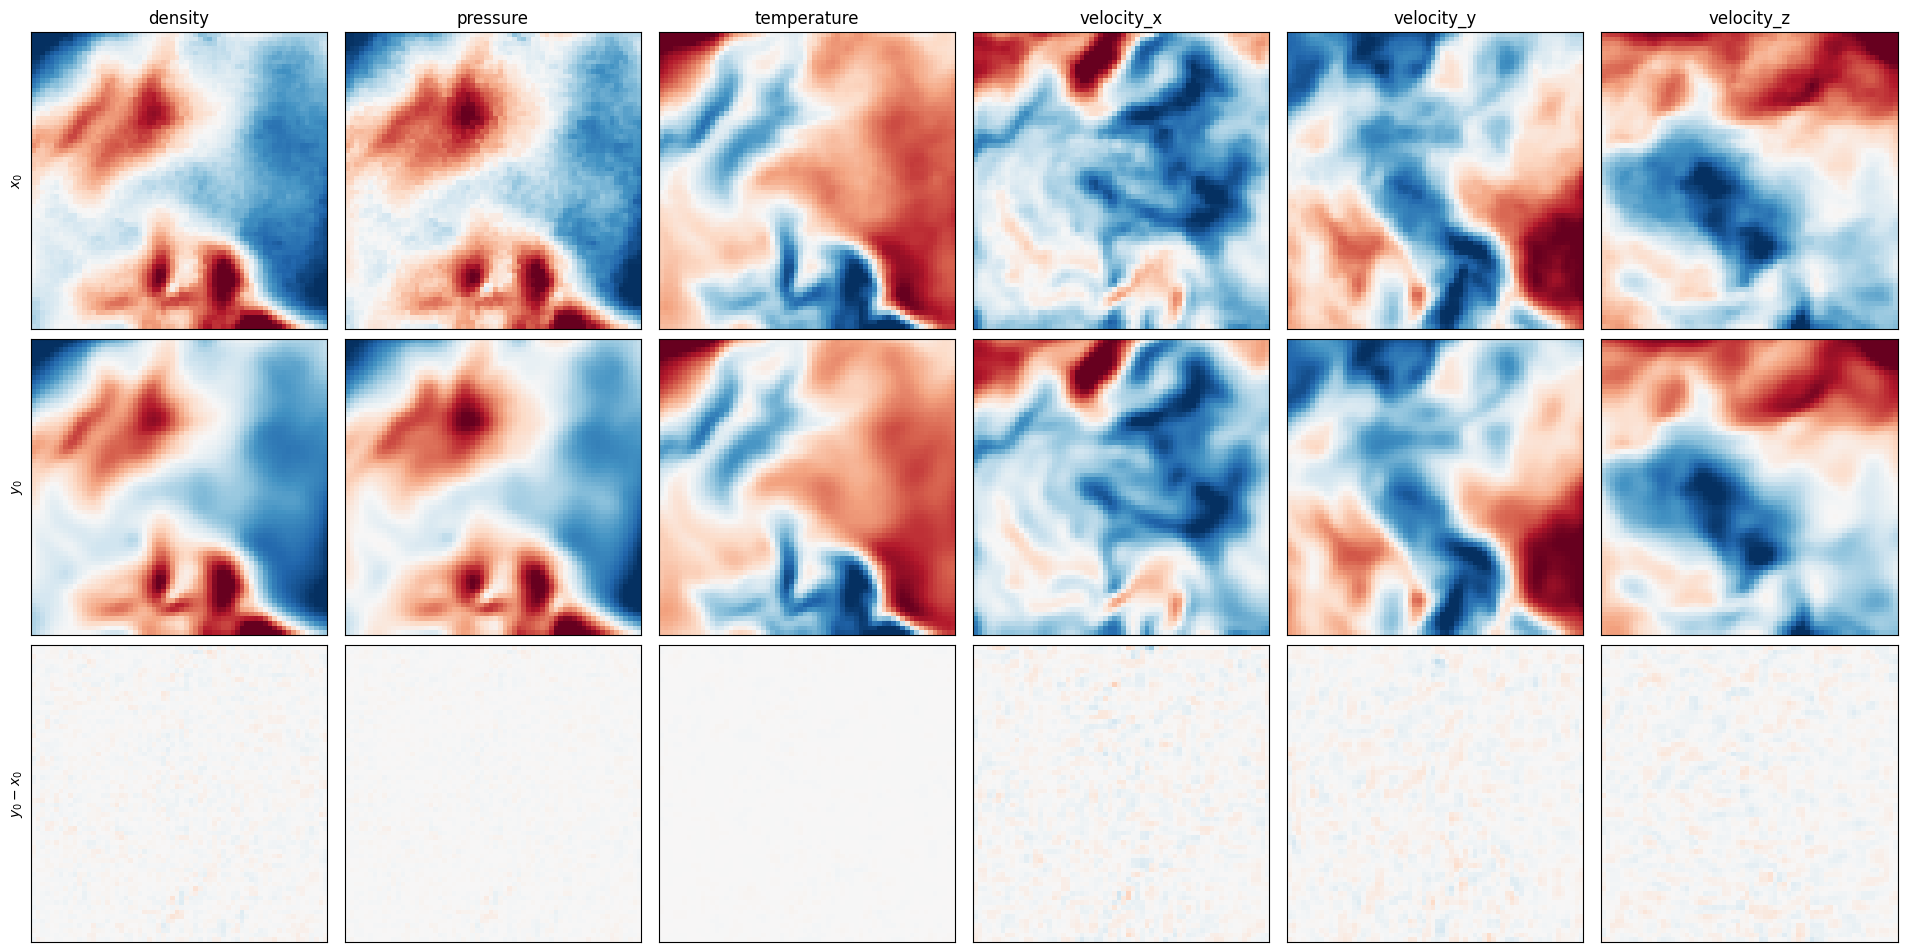

In [9]:
fig = plot_fields(x[:, 31:32], y[:, 31:32], fields=cfg.dataset.fields, tolerance=1.0, figsize=(3.2, 3.2))

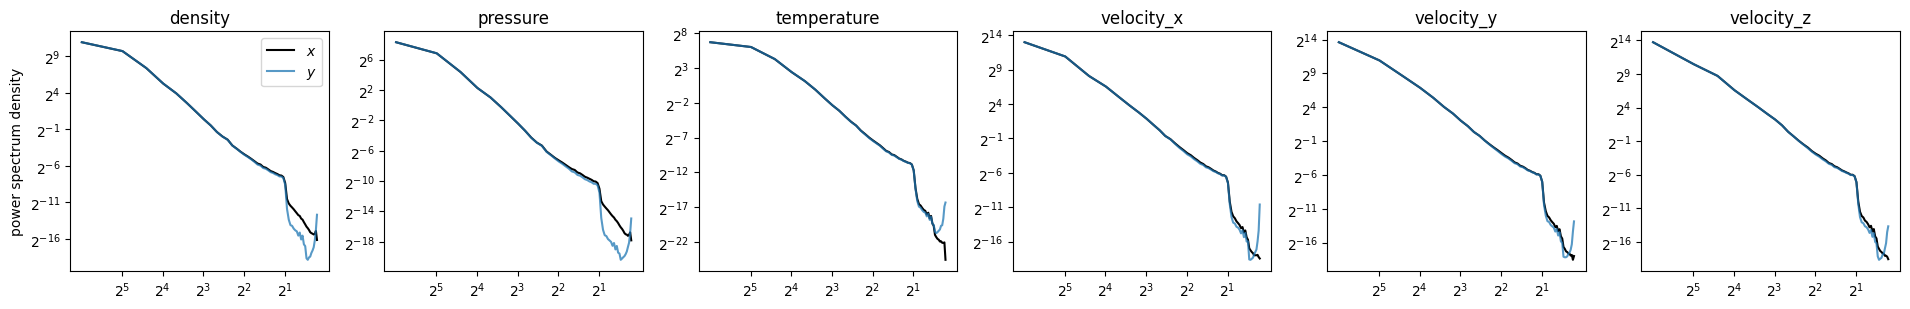

In [10]:
fig = plot_psd(x, y, fields=cfg.dataset.fields)